In [1]:
# Cell 1 - imports and load
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

df = pd.read_csv("aac_shelter_outcomes[1].csv")

In [2]:
# Cell 2 - inspect
print("shape:", df.shape)
print("columns:", df.columns.tolist())
df.head(5)


shape: (78256, 12)
columns: ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color', 'date_of_birth', 'datetime', 'monthyear', 'name', 'outcome_subtype', 'outcome_type', 'sex_upon_outcome']


,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [3]:
# Cell 3 - convert age to months
def convert_age_to_months(age_str):
    if pd.isnull(age_str): return np.nan
    s = str(age_str).lower().strip()
    m = re.match(r"(\d+(?:\.\d+)?)\s*(year|years|month|months|week|weeks|day|days)", s)
    if not m: return np.nan
    value = float(m.group(1)); unit = m.group(2)
    if "year" in unit: return value * 12
    if "month" in unit: return value
    if "week" in unit: return value * 0.25
    if "day" in unit: return value / 30
    return np.nan

df["AgeMonths"] = df["age_upon_outcome"].apply(convert_age_to_months)
df["AgeMonths"].describe()


count    78248.000000
mean        25.597772
std         34.743401
min          0.000000
25%          3.000000
50%         12.000000
75%         36.000000
max        300.000000
Name: AgeMonths, dtype: float64

In [4]:
# Cell 4 - create a binary target: Adopted (1) vs Not (0)
df["target_binary"] = df["outcome_type"].apply(lambda x: 1 if str(x).strip().lower()=="adoption" else 0)
print("target distribution (binary):")
print(df["target_binary"].value_counts(normalize=True))


target distribution (binary):
target_binary
0    0.576876
1    0.423124
Name: proportion, dtype: float64


In [5]:
# Cell 5 - drop rows missing target or AgeMonths; fill other missing
df = df.dropna(subset=["target_binary", "AgeMonths"])   # must have target and age
# Fill categorical missing with "Unknown"
for c in ["animal_type","breed","color","sex_upon_outcome","outcome_subtype"]:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown").astype(str)


In [6]:
# Cell 6 - select and create features
# create gender + neuter flags from sex_upon_outcome
def get_gender(x):
    s = str(x).lower()
    if "male" in s: return "Male"
    if "female" in s: return "Female"
    return "Unknown"

df["Gender"] = df["sex_upon_outcome"].apply(get_gender)
df["IsNeutered"] = df["sex_upon_outcome"].apply(lambda x: 1 if ("neutered" in str(x).lower() or "spayed" in str(x).lower()) else 0)

# features to use
features = ["animal_type","color","AgeMonths","Gender","IsNeutered"]
# if breed exists, we'll include a frequency encoding
if "breed" in df.columns:
    features.append("breed_freq")
    breed_freq = df["breed"].value_counts(normalize=True).to_dict()
    df["breed_freq"] = df["breed"].map(breed_freq).fillna(0)
X = df[features].copy()
y = df["target_binary"].copy()
print("X shape, y shape:", X.shape, y.shape)


X shape, y shape: (78248, 6) (78248,)


In [7]:
# Cell 7 - encode categories
le = LabelEncoder()
X_enc = X.copy()
for col in ["animal_type","color","Gender"]:
    X_enc[col] = le.fit_transform(X_enc[col].astype(str))
# numeric columns remain numeric: AgeMonths, IsNeutered, breed_freq
X_enc.head()


,animal_type,color,AgeMonths,Gender,IsNeutered,breed_freq
0,1,321,0.5,0,0,0.298206
1,2,474,12.0,0,1,0.004907
2,2,119,12.0,0,1,0.002990
3,2,463,108.0,0,1,0.005010
4,4,122,5.0,1,0,0.016422


In [8]:
# Cell 8 - split (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.20, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (62598, 6) Test size: (15650, 6)


In [9]:
# Cell 9 - train model and evaluate
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7557827476038339
F1 score: 0.7137936198891718
Classification report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79      9027
           1       0.71      0.72      0.71      6623

    accuracy                           0.76     15650
   macro avg       0.75      0.75      0.75     15650
weighted avg       0.76      0.76      0.76     15650



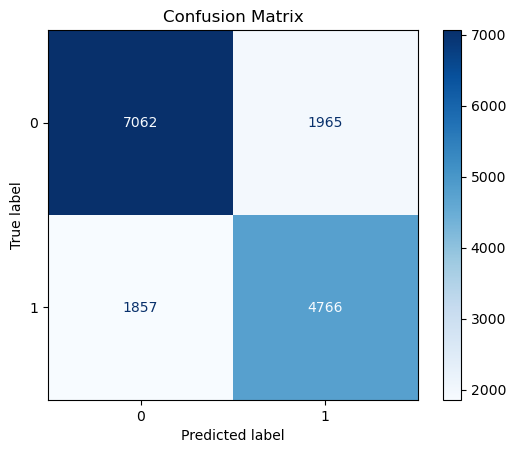

Top features:
 IsNeutered     0.329112
AgeMonths      0.242249
color          0.188332
breed_freq     0.187021
Gender         0.031324
animal_type    0.021962
dtype: float64


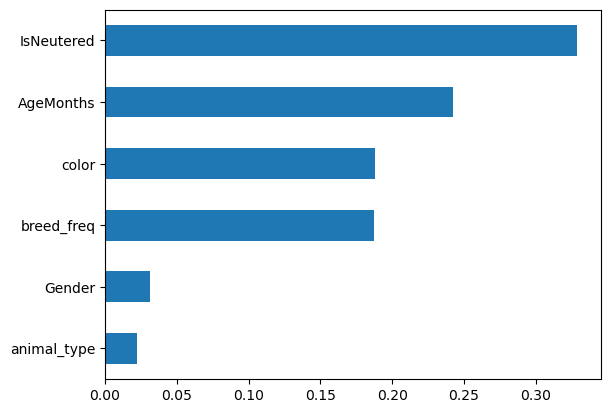

In [10]:
# Cell 10 - confusion matrix and feature importance
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# feature importance
fi = pd.Series(model.feature_importances_, index=X_enc.columns).sort_values(ascending=False)
print("Top features:\n", fi.head(10))
fi.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.show()


In [11]:
# Cell 11 - save model and a small predict helper
import joblib, os
os.makedirs("outputs/models", exist_ok=True)
joblib.dump(model, "outputs/models/pet_adopt_rf.joblib")

def predict_sample(sample_dict):
    # sample_dict must have keys: animal_type,color,AgeMonths,Gender,IsNeutered,breed (optional)
    row = {}
    row["animal_type"] = sample_dict.get("animal_type","Unknown")
    row["color"] = sample_dict.get("color","Unknown")
    row["AgeMonths"] = sample_dict.get("AgeMonths", df["AgeMonths"].median())
    row["Gender"] = sample_dict.get("Gender","Unknown")
    row["IsNeutered"] = sample_dict.get("IsNeutered",0)
    if "breed" in sample_dict:
        row["breed_freq"] = breed_freq.get(sample_dict["breed"], 0)
    # encode
    row_df = pd.DataFrame([row])
    for col in ["animal_type","color","Gender"]:
        row_df[col] = LabelEncoder().fit(list(X[col].astype(str).unique())).transform(row_df[col].astype(str))
    # ensure column order
    row_df = row_df[X_enc.columns]
    prob = model.predict_proba(row_df)[:,1][0]
    return prob

In [12]:
# example
print("Saved model. Example prediction (probability of adoption):",
      predict_sample({"animal_type":"Dog","color":"Brown","AgeMonths":24,"Gender":"Male","IsNeutered":1,"breed":"Labrador Mix"}))

Saved model. Example prediction (probability of adoption): 0.4863717532467534


In [17]:
df_dashboard=df[[
    "animal_type","breed","color","AgeMonths","Gender","IsNeutered","outcome_type","target_binary"
]]
df_dashboard.to_csv("pet_adoption_dashboard.csv",index=False)

In [18]:
import os
os.getcwd()

'C:\\Users\\sinchana bhat'

In [19]:
os.listdir()

['-1.14-windows.xml',
 '.anaconda',
 '.conda',
 '.condarc',
 '.continuum',
 '.eclipse',
 '.ipynb_checkpoints',
 '.ipython',
 '.jupyter',
 '.matplotlib',
 '.ms-ad',
 '.p2',
 '.vscode',
 'aac_shelter_outcomes[1].csv',
 'anaconda3',
 'animal_outcome_prediction.ipynb',
 'AppData',
 'Application Data',
 'archive (1).zip',
 'bhat',
 'bscjava',
 'carsales.csv',
 'codelabs',
 'Contacts',
 'Cookies',
 'course2.ipynb',
 'course_pandas_dvh.ipynb',
 'CrossDevice',
 'data description.ipynb',
 'data visualization 54.ipynb',
 'data_preparation(vid 44).ipynb',
 'Desktop',
 'Documents',
 'Downloads',
 'eclipse',
 'Favorites',
 'IntelGraphicsProfiles',
 'Links',
 'Local Settings',
 'Microsoft',
 'Music',
 'My Documents',
 'NetHood',
 'NTUSER.DAT',
 'ntuser.dat.LOG1',
 'ntuser.dat.LOG2',
 'NTUSER.DAT{f3fda6ad-6658-11f0-acfa-c4da601e615d}.TM.blf',
 'NTUSER.DAT{f3fda6ad-6658-11f0-acfa-c4da601e615d}.TMContainer00000000000000000001.regtrans-ms',
 'NTUSER.DAT{f3fda6ad-6658-11f0-acfa-c4da601e615d}.TMContainer0